In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
df=pd.read_csv('IOC-BSE.csv')
df.head()

,date,open,high,low,close,volume,dividend_amount
0,2005-01-03,515.00,522.0,514.50,515.95,185968.0,0.0
1,2005-01-04,517.55,525.9,516.55,521.90,925352.0,0.0
2,2005-01-05,523.55,524.0,489.00,504.55,456880.0,0.0
3,2005-01-06,500.05,507.0,493.00,502.15,620792.0,0.0
4,2005-01-07,502.00,502.0,494.05,497.15,525952.0,0.0


In [17]:
df.describe()

,open,high,low,close,volume,dividend_amount
count,4083.000000,4083.000000,4083.000000,4083.000000,4.083000e+03,4083.000000
mean,334.346669,339.498714,328.446118,333.344538,7.948214e+05,0.016547
std,139.706389,142.438077,136.808588,139.271686,9.987780e+05,0.279426
min,72.000000,73.450000,71.150000,71.550000,8.456000e+03,0.000000
25%,248.225000,252.000000,245.200000,248.350000,2.667970e+05,0.000000
50%,349.000000,355.300000,342.650000,348.550000,4.947280e+05,0.000000
75%,428.000000,434.000000,420.450000,425.750000,9.453280e+05,0.000000
max,794.000000,809.900000,776.950000,794.250000,1.720566e+07,9.500000


In [18]:
df.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
dividend_amount,0


In [19]:
df.shape

(4083, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4083 entries, 0 to 4082
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             4083 non-null   object 
 1   open             4083 non-null   float64
 2   high             4083 non-null   float64
 3   low              4083 non-null   float64
 4   close            4083 non-null   float64
 5   volume           4083 non-null   float64
 6   dividend_amount  4083 non-null   float64
dtypes: float64(6), object(1)
memory usage: 223.4+ KB


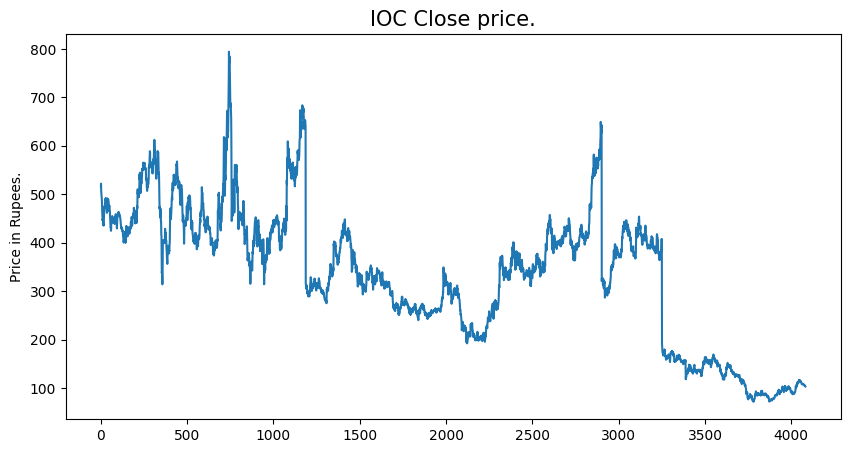

In [20]:
plt.figure(figsize=(10,5))
plt.plot(df['close'])
plt.title('IOC Close price.', fontsize=15)
plt.ylabel('Price in Rupees.')
plt.show()

In [25]:
# Preprocess Data
# Assuming 'Close' column exists
data = df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [26]:
# Split into train and test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [27]:
#Create sequences
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [28]:
x_train, y_train = create_dataset(train_data)
x_test, y_test = create_dataset(test_data)

In [29]:
# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [32]:
#Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train Model
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0436
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0020
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0017
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0012
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0012
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0012
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 9.1916e-04
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 7.9938e-04
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 9.5376e-04
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 7.9845e-04
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 8.1395e-04
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 6.3925e-04
Epoch 13/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.4908e-04
Epoch 14/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 5.8241e-04
Ep

In [34]:
# Predict and Inverse Transform
predicted = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


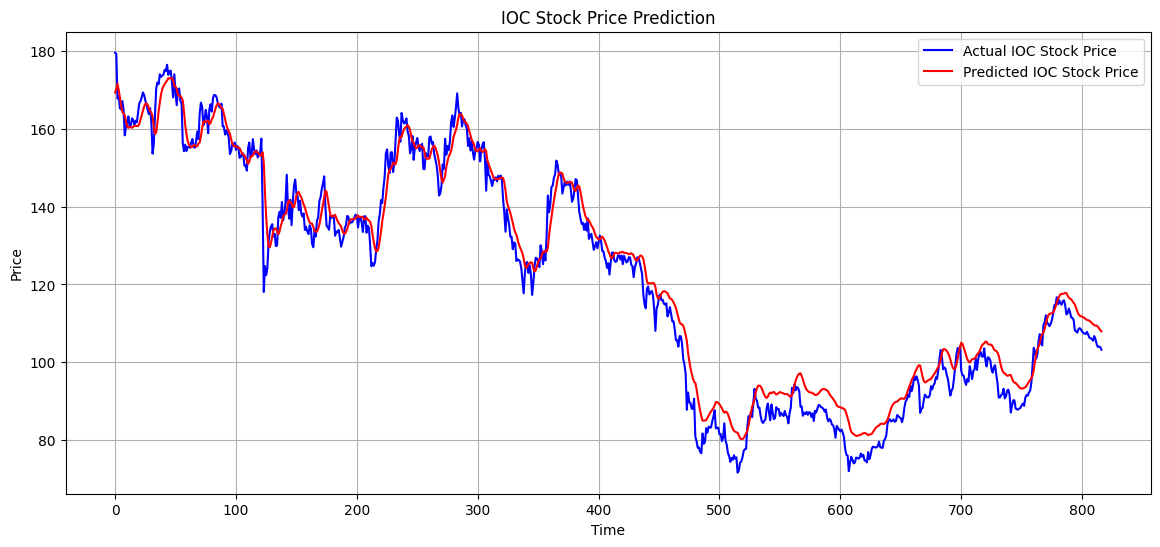

In [35]:
# Visualize
plt.figure(figsize=(14, 6))
plt.plot(real_prices, color='blue', label='Actual IOC Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted IOC Stock Price')
plt.title('IOC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# RMSE
rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f"Root Mean Square Error: {rmse:.4f}")

Root Mean Square Error: 5.0188


In [39]:
# Display Predicted vs Actual Prices
predicted_df = pd.DataFrame({
    'Actual Price': real_prices.flatten(),
    'Predicted Price': predicted_prices.flatten()
})

In [40]:
# Show the first few rows
print(predicted_df.head(10))

   Actual Price  Predicted Price
0        179.60       169.347473
1        179.30       170.393097
2        167.80       171.602036
3        168.35       169.971451
4        165.30       168.107407
5        165.00       166.006760
6        167.15       164.392380
7        164.95       163.904953
8        158.35       163.484573
9        160.55       161.802383


In [43]:
# Get corresponding dates for the test set
dates = df['date'].values  # assuming 'Date' column exists
dates = dates[-len(real_prices):]  # align with actual/predicted data

# Create DataFrame with Date, Actual, Predicted
predicted_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': real_prices.flatten(),
    'Predicted Price': predicted_prices.flatten()
})

# Display first few rows
print(predicted_df.head(10))

# Save to CSV
predicted_df.to_csv('IOC_Predicted_vs_Actual.csv', index=False)
print("File 'IOC_Predicted_vs_Actual.csv' has been saved with Date column.")

         Date  Actual Price  Predicted Price
0  2018-04-09        179.60       169.347473
1  2018-04-10        179.30       170.393097
2  2018-04-11        167.80       171.602036
3  2018-04-12        168.35       169.971451
4  2018-04-13        165.30       168.107407
5  2018-04-16        165.00       166.006760
6  2018-04-17        167.15       164.392380
7  2018-04-18        164.95       163.904953
8  2018-04-19        158.35       163.484573
9  2018-04-20        160.55       161.802383
File 'IOC_Predicted_vs_Actual.csv' has been saved with Date column.
